# V.A. Project

## Election timeout parameter evaluation

Experiment to verify what is the minimum timeout value for different system occupancies.

Run with version v3.4

In [1]:
# Library import

libFolder = "TR.AI.NS" # Library name

import sys, os
sys.path.append( os.path.join(os.path.dirname(sys.path[0])) + "/" + libFolder )


from Train import Train
from Client import Client, CliModes
from Network import Network

import csv
import numpy as np
from random import randint
import time
import matplotlib.pyplot as plt
from math import sqrt
import pandas as pd

In [31]:
# Setting the simulation conditions

# TODO!!! Escolher o mapa
mapPath = "../TR.AI.NS/map_grid"    # Map file path

cliDataFile = "datasets/normal_map-grid_60rep_2000iter.npz"

total_steps_run = -1              # Variable to limit the amount of simulation loops to be performed
total_clients_finished = 60       # Variable to limit the amount of clients to be delivered

simRepeat = 50                     # Number of times each simulation is repeated (to garner statistics)

trainSpeed = 20         # Speed the trains moves in the railway network the map (m/s)

logName = "/Volumes/Amy's HDD/TCC - TRAINS/log_simulation-timeout-v3.txt"     # Output log file. Stores all states of all trains and 
                                                # clients during each simulation loop

In [32]:
# Different frequency of clients to be analyzed
f_client = [25, 20, 15, 10, 5]

# Initial timeout values
init_timeout = [45, 45, 50, 50, 70]

# Number of trams
n_trams = 15    # The most extreme case seen, in the matter of number of messages exchanged

# Broadcast radius
cliR = 0.4      # Most of the time, the optimal parameter

# Simulation step speed
step_speed = 1

In [33]:
min_timeouts = {}

In [34]:
# Loading client creation dataset

client_dataset = np.load(cliDataFile)
client_creation = client_dataset.get("client")
client_position = client_dataset.get("init_stat")
client_destination = client_dataset.get("fin_stat")

In [35]:
# Auxiliary classes

class Simulation:
    def __init__(self):
        self.devices = []
        self.trainRange = 0
        self.clientRange = 0

Reading map file (../TR.AI.NS/map_grid)
	Going over graph info
	 - Map contains 81 vertices and 144 edges
	Going over vertices positions
	 - Got positions of the 81 vertices. 19 are stations
	Going over graph edges
	 - Read over 144 edges in graph


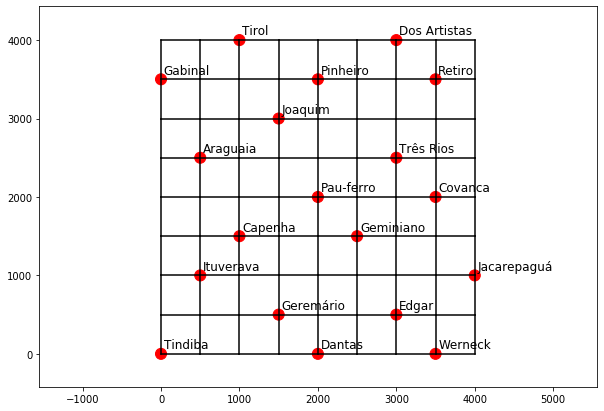

In [36]:
# Loading map

print("Reading map file (%s)" % mapPath)

# Getting CSV file names
graphInfo = "%s/Sheet 1-Graph Info.csv" % mapPath
vertices = "%s/Sheet 1-Vertices Positions.csv" % mapPath
connections = "%s/Sheet 1-Connection Matrix.csv" % mapPath


# Reading Graph Info table
print("\tGoing over graph info")

nVertices = 0
nEdges = 0
map_size = 0
with open(graphInfo) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            if not row[0] == "Number of vertices":
                raise Exception("Wrong input file format. See map input format")
            nVertices = int(row[1])
        elif line_count == 1:
            if not row[0] == "Number of connections":
                raise Exception("Wrong input file format. See map input format")
            nEdges = int(row[1])
        else:
            if not row[0] == "Map size":
                raise Exception("Wrong input file format. See map input format")
            map_size = float(row[1])
        line_count += 1
                                
    print("\t - Map contains %d vertices and %d edges" % (nVertices, nEdges))

# Reading Vertices Positions table
print("\tGoing over vertices positions")
                                
vert_pos = []
stoppingPoints = {}
stoppingPointsPos = []
with open(vertices) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    line_count = -1
    for row in csv_reader:
        if line_count == -1:
            line_count += 1
            continue
        vert_pos += [(float(row[1]), float(row[2]))]
        if row[0][0] != "_":
            stoppingPoints[row[0]] = line_count
            stoppingPointsPos += [(float(row[1]), float(row[2]))]
        line_count += 1
    if line_count != nVertices:
        raise Exception("Wrong input file format. The number of vertices given doesn't match the number of vertices specified")
    print("\t - Got positions of the %d vertices. %d are stations" %
          (nVertices, len(stoppingPoints.keys())))
                                
# Reading Connection Matrix table
print("\tGoing over graph edges")
                                
edges = np.ndarray(shape=(nVertices, nVertices), dtype=float)
edges.fill(-1)
                                
# Availability dictionary
availability = {}
                                
with open(connections) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    line_count = 0
    edge_count = 0
    for row in csv_reader:
        for i in range(nVertices):
            if row[i] != "":
                edges[line_count][i] = float(row[i])
                if line_count != i:
                    a = max(line_count, i)
                    b = min(line_count, i)
                    availability[ (a, b) ] = True
                if line_count > i:
                    edge_count += 1
        line_count += 1
    if nEdges != edge_count:
        raise Exception("Wrong input file format. Number of edges given doesn't match the specified number")
    print("\t - Read over %d edges in graph" % edge_count)

    
# Printing the map
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
ax.axis('equal')

nEdgesDrawn = 0
for i in range(nVertices):
    for j in range(nVertices):
        if j >= i:
            break
        if edges[i][j] > 0:
            ax.plot([vert_pos[i][0], vert_pos[j][0]], [vert_pos[i][1], vert_pos[j][1]], 'k', zorder=-4)
            nEdgesDrawn += 1

xmin, xmax, ymin, ymax = ax.axis()
scale = (ymax-ymin) * .016  # Scale fator to print visible circles
for ponto in stoppingPoints.keys():
    pos = vert_pos[stoppingPoints[ponto]]
    c = plt.Circle(pos, radius=scale, color='r', zorder=-5)
    ax.add_patch(c)
    ax.text(pos[0] + scale*.5, pos[1] + scale, ponto, fontsize=12, wrap=True, zorder=-3)

xmin, xmax, ymin, ymax = ax.axis()
diverge = .05
xmin = xmin - (xmax - xmin) * diverge
xmax = xmax + (xmax - xmin) * diverge
ymin = ymin - (ymax - ymin) * diverge
ymax = ymax + (ymax - ymin) * diverge
ax.axis([xmin, xmax, ymin, ymax])

plt.show()

In [37]:
# logFile = open(logName, "w")

In [38]:
fIdx = 0

timeout = init_timeout[fIdx]

sim = Simulation()
net = Network(sim, log=False)
sim.clientRange = int(map_size * cliR)
sim.trainRange = 3 * sim.clientRange

try:
    while timeout >= 0:
        print("Timeout analysis for f_c = {}. Value: {}".format(f_client[fIdx], timeout))
        
        deliveryTimeList = []
        waitTimeList = []
        answTimeList = []
        trainDistanceRun = []

        for turn in range(simRepeat):
            print("Simulation with {} trains, range {}. Turn {}".
                            format(n_trams, cliR, turn+1))

            waitingTime = {}
            answerTime = {}
            deliveryTime = {}

            sim.devices = []

            for key in availability.keys():
                availability[key] = True

            # Creating tram objects
            v_step = step_speed

            for i in range(n_trams):
                idx = randint(0, len(stoppingPointsPos) - 1)
                pos = stoppingPointsPos[ idx ]
                tr = Train(i, pos, v_step, mapPath, availability, net, vMax = trainSpeed, log=False)
                # Altering tram election timeout
                tr.nominalMaximumMsgWait = timeout     
                tr.maximumMsgWait = tr.nominalMaximumMsgWait / tr.vStep
                # NOTE: Should add a timeout update method!
                sim.devices += [tr]

            # Creating initial clients state
            nClients = 0
            currCli = 0.5
            clientList = []
            outingClients = {}

            # Looping simulation
            simTime = 0
            out_file = ""
            finished = False

            while not finished:
                clockcount = simTime * v_step
                clockcount = float(clockcount)
                hour = int(clockcount // 3600)
                clockcount %= 3600
                minutes = int(clockcount // 60)
                clockcount %= 60
                seconds = int (clockcount)
                # print( "Simulation counter: {:02d}:{:02d}:{:02d} ({} iterations)".
                #                             format(hour, minutes, seconds, simTime) )

                # Creating random clients
                if currCli < total_clients_finished:
                    r = client_creation[turn][simTime]
                    if r % f_client[fIdx] == 0:
                        init = client_position[turn][simTime]
                        fin = client_destination[turn][simTime]
                        if fin == init:
                            fin += 1
                            if fin == len(stoppingPointsPos):
                                fin = 0
                        pos = stoppingPointsPos[init]
                        dest = stoppingPointsPos[fin]
                        cl = Client(currCli, pos, dest, v_step, mapPath, net, log=False)
                        sim.devices += [cl]
                        clientList += [cl]
                        currCli += 1

                # Run all devices
                for device in sim.devices:
                    device.step()

                for client in clientList:
                    # Remove clients from list
                    if client.mode == CliModes.dropoff:
                        if client not in outingClients.keys():
                            outingClients[client] = 0
                        else:
                            outingClients[client] += 1
                        if outingClients[client] >= 10:
                            # Getting client waiting time statistics
                            waitingTime[client.id] = client.waitingTime*v_step
                            answerTime[client.id] = client.timeTillRequest*v_step
                            deliveryTime[client.id] = client.serviceTime*v_step

                            # Removing client from simulation
                            sim.devices.remove(client)
                            clientList.remove(client)
                            client.kill()
                            nClients += 1

                # Simulation log
                out_file += "Simulation step {}, timer {}\n".format(simTime, simTime*v_step)
                for device in sim.devices:
                    out_file += "\tDevice {}, mode {}: position {}\n".format(device.id, device.mode, device.pos)
                    if isinstance(device, Train):
                        out_file += "\t  Processing request {}\n".format(device.unprocessedReqs)
                        out_file += "\t  Path {}\n".format(device.path)
                        out_file += "\t  Clients list {}\n".format(device.client)
                    elif isinstance(device, Client):
                        out_file += "\t  Destination: {}.\n".format(device.destiny)
                        out_file += "\t  Train that will pick me up {}\n".format(device.train)
                out_file += "\n"

                # Simulation step counter
                simTime += 1

                # Check for simulation closure
                if total_steps_run != -1:
                    if simTime >= total_steps_run:
                        finished = True
                elif nClients != -1:
                    if nClients >= total_clients_finished:
                        finished = True

            print("Finished simulation!")
            out_file += "The end"

            # logFile.write("Test with {} trains, {}th attempt\n\n{}\n\n\n".format(nTrains, turn+1, out_file))


            # Waiting time statistics

            # Average waiting time
            sumTime = 0
            for value in waitingTime.values():
                sumTime += value

            waitTimeList += [ sumTime/len(waitingTime.keys()) ]

            sumTime = 0
            for value in answerTime.values():
                sumTime += value

            answTimeList += [ sumTime/len(answerTime.keys()) ]

            sumTime = 0
            for value in deliveryTime.values():
                sumTime += value

            deliveryTimeList += [ sumTime/len(deliveryTime.keys()) ]

            # TODO: Make version that is normalized by distance!

            print("Average total waiting time for {} trains: {}".format(n_trams, deliveryTimeList[turn]))
            print("Serviced {} clients in {} simulation counts\n".format(len(deliveryTime.keys()), simTime))

            # Train distances
            sumDistance = 0
            for dev in sim.devices:
                if isinstance(dev, Train):
                    sumDistance += dev.totalDistanceRun

            trainDistanceRun += [sumDistance]

        print("\tTotal service time:\n", deliveryTimeList)
        # print("\tTotal distance traversed:\n", trainDistanceRun)
        print("\n\n")

        timeout = timeout - 5
        
except Exception as e:
    if (str(e) == "Client received two train assignments"):
        print()
        print("Found minimum timeout for f_c = {}: {}".format(f_client[fIdx], timeout))
        
        min_timeouts[f_client[fIdx]] = timeout

Timeout analysis for f_c = 25. Value: 45
Simulation with 15 trains, range 0.4. Turn 1
Finished simulation!
Average total waiting time for 15 trains: 289.5833333333333
Serviced 60 clients in 1518 simulation counts

Simulation with 15 trains, range 0.4. Turn 2
Finished simulation!
Average total waiting time for 15 trains: 253.46666666666667
Serviced 60 clients in 1974 simulation counts

Simulation with 15 trains, range 0.4. Turn 3
Finished simulation!
Average total waiting time for 15 trains: 284.18333333333334
Serviced 60 clients in 2082 simulation counts

Simulation with 15 trains, range 0.4. Turn 4
Finished simulation!
Average total waiting time for 15 trains: 274.3833333333333
Serviced 60 clients in 1954 simulation counts

Simulation with 15 trains, range 0.4. Turn 5
Finished simulation!
Average total waiting time for 15 trains: 309.75
Serviced 60 clients in 1909 simulation counts

Simulation with 15 trains, range 0.4. Turn 6
Finished simulation!
Average total waiting time for 15 tra

Finished simulation!
Average total waiting time for 15 trains: 264.4
Serviced 60 clients in 2131 simulation counts

Simulation with 15 trains, range 0.4. Turn 50
Finished simulation!
Average total waiting time for 15 trains: 346.8
Serviced 60 clients in 1704 simulation counts

	Total service time:
 [289.5833333333333, 253.46666666666667, 284.18333333333334, 274.3833333333333, 309.75, 293.46666666666664, 258.1666666666667, 314.2, 278.45, 266.76666666666665, 296.93333333333334, 265.26666666666665, 287.8833333333333, 305.76666666666665, 278.78333333333336, 270.06666666666666, 285.51666666666665, 257.23333333333335, 247.6, 283.23333333333335, 273.6, 223.46666666666667, 316.5, 291.18333333333334, 339.3833333333333, 265.4, 257.71666666666664, 342.3666666666667, 318.5833333333333, 248.9, 290.78333333333336, 285.31666666666666, 262.1, 281.56666666666666, 361.3666666666667, 271.71666666666664, 252.48333333333332, 291.98333333333335, 297.8333333333333, 316.15, 296.6333333333333, 259.766666666666

Finished simulation!
Average total waiting time for 15 trains: 244.58333333333334
Serviced 60 clients in 2421 simulation counts

Simulation with 15 trains, range 0.4. Turn 44
Finished simulation!
Average total waiting time for 15 trains: 308.98333333333335
Serviced 60 clients in 1589 simulation counts

Simulation with 15 trains, range 0.4. Turn 45
Finished simulation!
Average total waiting time for 15 trains: 260.23333333333335
Serviced 60 clients in 1928 simulation counts

Simulation with 15 trains, range 0.4. Turn 46
Finished simulation!
Average total waiting time for 15 trains: 250.38333333333333
Serviced 60 clients in 1770 simulation counts

Simulation with 15 trains, range 0.4. Turn 47
Finished simulation!
Average total waiting time for 15 trains: 253.13333333333333
Serviced 60 clients in 2092 simulation counts

Simulation with 15 trains, range 0.4. Turn 48
Finished simulation!
Average total waiting time for 15 trains: 313.96666666666664
Serviced 60 clients in 1895 simulation coun

Finished simulation!
Average total waiting time for 15 trains: 250.36666666666667
Serviced 60 clients in 1678 simulation counts

Simulation with 15 trains, range 0.4. Turn 38
Finished simulation!
Average total waiting time for 15 trains: 283.1166666666667
Serviced 60 clients in 1806 simulation counts

Simulation with 15 trains, range 0.4. Turn 39
Finished simulation!
Average total waiting time for 15 trains: 282.5833333333333
Serviced 60 clients in 2126 simulation counts

Simulation with 15 trains, range 0.4. Turn 40
Finished simulation!
Average total waiting time for 15 trains: 258.8833333333333
Serviced 60 clients in 1820 simulation counts

Simulation with 15 trains, range 0.4. Turn 41
Finished simulation!
Average total waiting time for 15 trains: 256.3833333333333
Serviced 60 clients in 1516 simulation counts

Simulation with 15 trains, range 0.4. Turn 42
Finished simulation!
Average total waiting time for 15 trains: 264.56666666666666
Serviced 60 clients in 2112 simulation counts



Finished simulation!
Average total waiting time for 15 trains: 212.75
Serviced 60 clients in 1748 simulation counts

Simulation with 15 trains, range 0.4. Turn 31
Finished simulation!
Average total waiting time for 15 trains: 260.05
Serviced 60 clients in 1824 simulation counts

Simulation with 15 trains, range 0.4. Turn 32
Finished simulation!
Average total waiting time for 15 trains: 269.55
Serviced 60 clients in 1689 simulation counts

Simulation with 15 trains, range 0.4. Turn 33
Finished simulation!
Average total waiting time for 15 trains: 242.36666666666667
Serviced 60 clients in 1798 simulation counts

Simulation with 15 trains, range 0.4. Turn 34
Finished simulation!
Average total waiting time for 15 trains: 251.96666666666667
Serviced 60 clients in 1615 simulation counts

Simulation with 15 trains, range 0.4. Turn 35
Finished simulation!
Average total waiting time for 15 trains: 344.5833333333333
Serviced 60 clients in 1787 simulation counts

Simulation with 15 trains, range 

Finished simulation!
Average total waiting time for 15 trains: 230.45
Serviced 60 clients in 1810 simulation counts

Simulation with 15 trains, range 0.4. Turn 25
Finished simulation!
Average total waiting time for 15 trains: 330.85
Serviced 60 clients in 1600 simulation counts

Simulation with 15 trains, range 0.4. Turn 26
Finished simulation!
Average total waiting time for 15 trains: 248.48333333333332
Serviced 60 clients in 1636 simulation counts

Simulation with 15 trains, range 0.4. Turn 27
Finished simulation!
Average total waiting time for 15 trains: 246.93333333333334
Serviced 60 clients in 1885 simulation counts

Simulation with 15 trains, range 0.4. Turn 28
Finished simulation!
Average total waiting time for 15 trains: 289.85
Serviced 60 clients in 1833 simulation counts

Simulation with 15 trains, range 0.4. Turn 29
Finished simulation!
Average total waiting time for 15 trains: 317.2
Serviced 60 clients in 1966 simulation counts

Simulation with 15 trains, range 0.4. Turn 30

Finished simulation!
Average total waiting time for 15 trains: 224.93333333333334
Serviced 60 clients in 1911 simulation counts

Simulation with 15 trains, range 0.4. Turn 19
Finished simulation!
Average total waiting time for 15 trains: 222.45
Serviced 60 clients in 2095 simulation counts

Simulation with 15 trains, range 0.4. Turn 20
Finished simulation!
Average total waiting time for 15 trains: 287.35
Serviced 60 clients in 2086 simulation counts

Simulation with 15 trains, range 0.4. Turn 21
Finished simulation!
Average total waiting time for 15 trains: 261.6
Serviced 60 clients in 1753 simulation counts

Simulation with 15 trains, range 0.4. Turn 22
Finished simulation!
Average total waiting time for 15 trains: 213.41666666666666
Serviced 60 clients in 2084 simulation counts

Simulation with 15 trains, range 0.4. Turn 23
Finished simulation!
Average total waiting time for 15 trains: 243.03333333333333
Serviced 60 clients in 1794 simulation counts

Simulation with 15 trains, range 

Finished simulation!
Average total waiting time for 15 trains: 238.73333333333332
Serviced 60 clients in 1592 simulation counts

Simulation with 15 trains, range 0.4. Turn 13
Finished simulation!
Average total waiting time for 15 trains: 276.7
Serviced 60 clients in 1964 simulation counts

Simulation with 15 trains, range 0.4. Turn 14
Finished simulation!
Average total waiting time for 15 trains: 222.86666666666667
Serviced 60 clients in 1951 simulation counts

Simulation with 15 trains, range 0.4. Turn 15
Finished simulation!
Average total waiting time for 15 trains: 231.0
Serviced 60 clients in 1937 simulation counts

Simulation with 15 trains, range 0.4. Turn 16
Finished simulation!
Average total waiting time for 15 trains: 244.53333333333333
Serviced 60 clients in 2103 simulation counts

Simulation with 15 trains, range 0.4. Turn 17
Finished simulation!
Average total waiting time for 15 trains: 255.23333333333332
Serviced 60 clients in 1885 simulation counts

Simulation with 15 tra

Finished simulation!
Average total waiting time for 15 trains: 238.61666666666667
Serviced 60 clients in 1941 simulation counts

Simulation with 15 trains, range 0.4. Turn 6
Finished simulation!
Average total waiting time for 15 trains: 260.8333333333333
Serviced 60 clients in 1844 simulation counts

Simulation with 15 trains, range 0.4. Turn 7
Finished simulation!
Average total waiting time for 15 trains: 226.03333333333333
Serviced 60 clients in 1984 simulation counts

Simulation with 15 trains, range 0.4. Turn 8
Finished simulation!
Average total waiting time for 15 trains: 258.1166666666667
Serviced 60 clients in 1936 simulation counts

Simulation with 15 trains, range 0.4. Turn 9
Finished simulation!
Average total waiting time for 15 trains: 251.11666666666667
Serviced 60 clients in 1703 simulation counts

Simulation with 15 trains, range 0.4. Turn 10
Finished simulation!
Average total waiting time for 15 trains: 249.85
Serviced 60 clients in 2033 simulation counts

Simulation wit

In [39]:
fIdx = 1

timeout = init_timeout[fIdx]

sim = Simulation()
net = Network(sim, log=False)
sim.clientRange = int(map_size * cliR)
sim.trainRange = 3 * sim.clientRange

try:
    while timeout >= 0:
        print("Timeout analysis for f_c = {}. Value: {}".format(f_client[fIdx], timeout))
        
        deliveryTimeList = []
        waitTimeList = []
        answTimeList = []
        trainDistanceRun = []

        for turn in range(simRepeat):
            print("Simulation with {} trains, range {}. Turn {}".
                            format(n_trams, cliR, turn+1))

            waitingTime = {}
            answerTime = {}
            deliveryTime = {}

            sim.devices = []

            for key in availability.keys():
                availability[key] = True

            # Creating tram objects
            v_step = step_speed

            for i in range(n_trams):
                idx = randint(0, len(stoppingPointsPos) - 1)
                pos = stoppingPointsPos[ idx ]
                tr = Train(i, pos, v_step, mapPath, availability, net, vMax = trainSpeed, log=False)
                # Altering tram election timeout
                tr.nominalMaximumMsgWait = timeout     
                tr.maximumMsgWait = tr.nominalMaximumMsgWait / tr.vStep
                # NOTE: Should add a timeout update method!
                sim.devices += [tr]

            # Creating initial clients state
            nClients = 0
            currCli = 0.5
            clientList = []
            outingClients = {}

            # Looping simulation
            simTime = 0
            out_file = ""
            finished = False

            while not finished:
                clockcount = simTime * v_step
                clockcount = float(clockcount)
                hour = int(clockcount // 3600)
                clockcount %= 3600
                minutes = int(clockcount // 60)
                clockcount %= 60
                seconds = int (clockcount)
                # print( "Simulation counter: {:02d}:{:02d}:{:02d} ({} iterations)".
                #                             format(hour, minutes, seconds, simTime) )

                # Creating random clients
                if currCli < total_clients_finished:
                    r = client_creation[turn][simTime]
                    if r % f_client[fIdx] == 0:
                        init = client_position[turn][simTime]
                        fin = client_destination[turn][simTime]
                        if fin == init:
                            fin += 1
                            if fin == len(stoppingPointsPos):
                                fin = 0
                        pos = stoppingPointsPos[init]
                        dest = stoppingPointsPos[fin]
                        cl = Client(currCli, pos, dest, v_step, mapPath, net, log=False)
                        sim.devices += [cl]
                        clientList += [cl]
                        currCli += 1

                # Run all devices
                for device in sim.devices:
                    device.step()

                for client in clientList:
                    # Remove clients from list
                    if client.mode == CliModes.dropoff:
                        if client not in outingClients.keys():
                            outingClients[client] = 0
                        else:
                            outingClients[client] += 1
                        if outingClients[client] >= 10:
                            # Getting client waiting time statistics
                            waitingTime[client.id] = client.waitingTime*v_step
                            answerTime[client.id] = client.timeTillRequest*v_step
                            deliveryTime[client.id] = client.serviceTime*v_step

                            # Removing client from simulation
                            sim.devices.remove(client)
                            clientList.remove(client)
                            client.kill()
                            nClients += 1

                # Simulation log
                out_file += "Simulation step {}, timer {}\n".format(simTime, simTime*v_step)
                for device in sim.devices:
                    out_file += "\tDevice {}, mode {}: position {}\n".format(device.id, device.mode, device.pos)
                    if isinstance(device, Train):
                        out_file += "\t  Processing request {}\n".format(device.unprocessedReqs)
                        out_file += "\t  Path {}\n".format(device.path)
                        out_file += "\t  Clients list {}\n".format(device.client)
                    elif isinstance(device, Client):
                        out_file += "\t  Destination: {}.\n".format(device.destiny)
                        out_file += "\t  Train that will pick me up {}\n".format(device.train)
                out_file += "\n"

                # Simulation step counter
                simTime += 1

                # Check for simulation closure
                if total_steps_run != -1:
                    if simTime >= total_steps_run:
                        finished = True
                elif nClients != -1:
                    if nClients >= total_clients_finished:
                        finished = True

            print("Finished simulation!")
            out_file += "The end"

            # logFile.write("Test with {} trains, {}th attempt\n\n{}\n\n\n".format(nTrains, turn+1, out_file))


            # Waiting time statistics

            # Average waiting time
            sumTime = 0
            for value in waitingTime.values():
                sumTime += value

            waitTimeList += [ sumTime/len(waitingTime.keys()) ]

            sumTime = 0
            for value in answerTime.values():
                sumTime += value

            answTimeList += [ sumTime/len(answerTime.keys()) ]

            sumTime = 0
            for value in deliveryTime.values():
                sumTime += value

            deliveryTimeList += [ sumTime/len(deliveryTime.keys()) ]

            # TODO: Make version that is normalized by distance!

            print("Average total waiting time for {} trains: {}".format(n_trams, deliveryTimeList[turn]))
            print("Serviced {} clients in {} simulation counts\n".format(len(deliveryTime.keys()), simTime))

            # Train distances
            sumDistance = 0
            for dev in sim.devices:
                if isinstance(dev, Train):
                    sumDistance += dev.totalDistanceRun

            trainDistanceRun += [sumDistance]

        print("\tTotal service time:\n", deliveryTimeList)
        # print("\tTotal distance traversed:\n", trainDistanceRun)
        print("\n\n")

        timeout = timeout - 5
        
except Exception as e:
    if (str(e) == "Client received two train assignments"):
        print()
        print("Found minimum timeout for f_c = {}: {}".format(f_client[fIdx], timeout))
        
        min_timeouts[f_client[fIdx]] = timeout

Timeout analysis for f_c = 20. Value: 45
Simulation with 15 trains, range 0.4. Turn 1
Finished simulation!
Average total waiting time for 15 trains: 307.0
Serviced 60 clients in 1803 simulation counts

Simulation with 15 trains, range 0.4. Turn 2
Finished simulation!
Average total waiting time for 15 trains: 291.81666666666666
Serviced 60 clients in 1677 simulation counts

Simulation with 15 trains, range 0.4. Turn 3
Finished simulation!
Average total waiting time for 15 trains: 399.78333333333336
Serviced 60 clients in 1864 simulation counts

Simulation with 15 trains, range 0.4. Turn 4
Finished simulation!
Average total waiting time for 15 trains: 271.81666666666666
Serviced 60 clients in 1641 simulation counts

Simulation with 15 trains, range 0.4. Turn 5
Finished simulation!
Average total waiting time for 15 trains: 288.8
Serviced 60 clients in 1756 simulation counts

Simulation with 15 trains, range 0.4. Turn 6
Finished simulation!
Average total waiting time for 15 trains: 373.483

Finished simulation!
Average total waiting time for 15 trains: 314.9
Serviced 60 clients in 1515 simulation counts

Simulation with 15 trains, range 0.4. Turn 50
Finished simulation!
Average total waiting time for 15 trains: 319.6
Serviced 60 clients in 1648 simulation counts

	Total service time:
 [307.0, 291.81666666666666, 399.78333333333336, 271.81666666666666, 288.8, 373.48333333333335, 383.98333333333335, 318.3, 316.26666666666665, 281.03333333333336, 294.43333333333334, 325.6166666666667, 326.15, 261.1, 294.95, 287.28333333333336, 323.3666666666667, 300.6333333333333, 278.6666666666667, 392.7, 288.68333333333334, 259.1166666666667, 288.75, 290.1333333333333, 323.0833333333333, 321.25, 345.65, 324.9, 307.46666666666664, 304.15, 260.3, 315.96666666666664, 272.01666666666665, 385.15, 392.4166666666667, 293.8666666666667, 331.68333333333334, 281.8333333333333, 319.1, 304.65, 356.53333333333336, 325.6, 343.76666666666665, 293.35, 290.8833333333333, 300.7, 270.1666666666667, 323.38333

Finished simulation!
Average total waiting time for 15 trains: 294.9
Serviced 60 clients in 1461 simulation counts

Simulation with 15 trains, range 0.4. Turn 44
Finished simulation!
Average total waiting time for 15 trains: 303.55
Serviced 60 clients in 1560 simulation counts

Simulation with 15 trains, range 0.4. Turn 45
Finished simulation!
Average total waiting time for 15 trains: 298.31666666666666
Serviced 60 clients in 1915 simulation counts

Simulation with 15 trains, range 0.4. Turn 46
Finished simulation!
Average total waiting time for 15 trains: 274.3666666666667
Serviced 60 clients in 1583 simulation counts

Simulation with 15 trains, range 0.4. Turn 47
Finished simulation!
Average total waiting time for 15 trains: 295.01666666666665
Serviced 60 clients in 1584 simulation counts

Simulation with 15 trains, range 0.4. Turn 48
Finished simulation!
Average total waiting time for 15 trains: 315.01666666666665
Serviced 60 clients in 1664 simulation counts

Simulation with 15 tra

Finished simulation!
Average total waiting time for 15 trains: 317.03333333333336
Serviced 60 clients in 1682 simulation counts

Simulation with 15 trains, range 0.4. Turn 38
Finished simulation!
Average total waiting time for 15 trains: 262.98333333333335
Serviced 60 clients in 1542 simulation counts

Simulation with 15 trains, range 0.4. Turn 39
Finished simulation!
Average total waiting time for 15 trains: 306.18333333333334
Serviced 60 clients in 1594 simulation counts

Simulation with 15 trains, range 0.4. Turn 40
Finished simulation!
Average total waiting time for 15 trains: 284.6333333333333
Serviced 60 clients in 1558 simulation counts

Simulation with 15 trains, range 0.4. Turn 41
Finished simulation!
Average total waiting time for 15 trains: 336.06666666666666
Serviced 60 clients in 1823 simulation counts

Simulation with 15 trains, range 0.4. Turn 42
Finished simulation!
Average total waiting time for 15 trains: 287.96666666666664
Serviced 60 clients in 1522 simulation count

Finished simulation!
Average total waiting time for 15 trains: 247.88333333333333
Serviced 60 clients in 1634 simulation counts

Simulation with 15 trains, range 0.4. Turn 32
Finished simulation!
Average total waiting time for 15 trains: 276.95
Serviced 60 clients in 1743 simulation counts

Simulation with 15 trains, range 0.4. Turn 33
Finished simulation!
Average total waiting time for 15 trains: 259.5
Serviced 60 clients in 2282 simulation counts

Simulation with 15 trains, range 0.4. Turn 34
Finished simulation!
Average total waiting time for 15 trains: 270.0
Serviced 60 clients in 1367 simulation counts

Simulation with 15 trains, range 0.4. Turn 35
Finished simulation!
Average total waiting time for 15 trains: 349.25
Serviced 60 clients in 1941 simulation counts

Simulation with 15 trains, range 0.4. Turn 36
Finished simulation!
Average total waiting time for 15 trains: 249.81666666666666
Serviced 60 clients in 1689 simulation counts

Simulation with 15 trains, range 0.4. Turn 37


Finished simulation!
Average total waiting time for 15 trains: 281.85
Serviced 60 clients in 1466 simulation counts

Simulation with 15 trains, range 0.4. Turn 26
Finished simulation!
Average total waiting time for 15 trains: 273.15
Serviced 60 clients in 1357 simulation counts

Simulation with 15 trains, range 0.4. Turn 27
Finished simulation!
Average total waiting time for 15 trains: 319.3666666666667
Serviced 60 clients in 1583 simulation counts

Simulation with 15 trains, range 0.4. Turn 28
Finished simulation!
Average total waiting time for 15 trains: 301.3666666666667
Serviced 60 clients in 1499 simulation counts

Simulation with 15 trains, range 0.4. Turn 29
Finished simulation!
Average total waiting time for 15 trains: 276.56666666666666
Serviced 60 clients in 1558 simulation counts

Simulation with 15 trains, range 0.4. Turn 30
Finished simulation!
Average total waiting time for 15 trains: 286.1166666666667
Serviced 60 clients in 1866 simulation counts

Simulation with 15 trai

Finished simulation!
Average total waiting time for 15 trains: 226.85
Serviced 60 clients in 1684 simulation counts

Simulation with 15 trains, range 0.4. Turn 20
Finished simulation!
Average total waiting time for 15 trains: 303.71666666666664
Serviced 60 clients in 1497 simulation counts

Simulation with 15 trains, range 0.4. Turn 21
Finished simulation!
Average total waiting time for 15 trains: 264.05
Serviced 60 clients in 1852 simulation counts

Simulation with 15 trains, range 0.4. Turn 22
Finished simulation!
Average total waiting time for 15 trains: 230.81666666666666
Serviced 60 clients in 1763 simulation counts

Simulation with 15 trains, range 0.4. Turn 23
Finished simulation!
Average total waiting time for 15 trains: 286.0
Serviced 60 clients in 1622 simulation counts

Simulation with 15 trains, range 0.4. Turn 24
Finished simulation!
Average total waiting time for 15 trains: 262.0
Serviced 60 clients in 1740 simulation counts

Simulation with 15 trains, range 0.4. Turn 25


Finished simulation!
Average total waiting time for 15 trains: 296.76666666666665
Serviced 60 clients in 1555 simulation counts

Simulation with 15 trains, range 0.4. Turn 14
Finished simulation!
Average total waiting time for 15 trains: 223.58333333333334
Serviced 60 clients in 1376 simulation counts

Simulation with 15 trains, range 0.4. Turn 15
Finished simulation!
Average total waiting time for 15 trains: 274.15
Serviced 60 clients in 1885 simulation counts

Simulation with 15 trains, range 0.4. Turn 16
Finished simulation!
Average total waiting time for 15 trains: 255.58333333333334
Serviced 60 clients in 1568 simulation counts

Simulation with 15 trains, range 0.4. Turn 17
Finished simulation!
Average total waiting time for 15 trains: 262.6333333333333
Serviced 60 clients in 1374 simulation counts

Simulation with 15 trains, range 0.4. Turn 18
Finished simulation!
Average total waiting time for 15 trains: 251.18333333333334
Serviced 60 clients in 1681 simulation counts

Simulatio

In [40]:
fIdx = 2

timeout = init_timeout[fIdx]

sim = Simulation()
net = Network(sim, log=False)
sim.clientRange = int(map_size * cliR)
sim.trainRange = 3 * sim.clientRange

try:
    while timeout >= 0:
        print("Timeout analysis for f_c = {}. Value: {}".format(f_client[fIdx], timeout))
        
        deliveryTimeList = []
        waitTimeList = []
        answTimeList = []
        trainDistanceRun = []

        for turn in range(simRepeat):
            print("Simulation with {} trains, range {}. Turn {}".
                            format(n_trams, cliR, turn+1))

            waitingTime = {}
            answerTime = {}
            deliveryTime = {}

            sim.devices = []

            for key in availability.keys():
                availability[key] = True

            # Creating tram objects
            v_step = step_speed

            for i in range(n_trams):
                idx = randint(0, len(stoppingPointsPos) - 1)
                pos = stoppingPointsPos[ idx ]
                tr = Train(i, pos, v_step, mapPath, availability, net, vMax = trainSpeed, log=False)
                # Altering tram election timeout
                tr.nominalMaximumMsgWait = timeout     
                tr.maximumMsgWait = tr.nominalMaximumMsgWait / tr.vStep
                # NOTE: Should add a timeout update method!
                sim.devices += [tr]

            # Creating initial clients state
            nClients = 0
            currCli = 0.5
            clientList = []
            outingClients = {}

            # Looping simulation
            simTime = 0
            out_file = ""
            finished = False

            while not finished:
                clockcount = simTime * v_step
                clockcount = float(clockcount)
                hour = int(clockcount // 3600)
                clockcount %= 3600
                minutes = int(clockcount // 60)
                clockcount %= 60
                seconds = int (clockcount)
                # print( "Simulation counter: {:02d}:{:02d}:{:02d} ({} iterations)".
                #                             format(hour, minutes, seconds, simTime) )

                # Creating random clients
                if currCli < total_clients_finished:
                    r = client_creation[turn][simTime]
                    if r % f_client[fIdx] == 0:
                        init = client_position[turn][simTime]
                        fin = client_destination[turn][simTime]
                        if fin == init:
                            fin += 1
                            if fin == len(stoppingPointsPos):
                                fin = 0
                        pos = stoppingPointsPos[init]
                        dest = stoppingPointsPos[fin]
                        cl = Client(currCli, pos, dest, v_step, mapPath, net, log=False)
                        sim.devices += [cl]
                        clientList += [cl]
                        currCli += 1

                # Run all devices
                for device in sim.devices:
                    device.step()

                for client in clientList:
                    # Remove clients from list
                    if client.mode == CliModes.dropoff:
                        if client not in outingClients.keys():
                            outingClients[client] = 0
                        else:
                            outingClients[client] += 1
                        if outingClients[client] >= 10:
                            # Getting client waiting time statistics
                            waitingTime[client.id] = client.waitingTime*v_step
                            answerTime[client.id] = client.timeTillRequest*v_step
                            deliveryTime[client.id] = client.serviceTime*v_step

                            # Removing client from simulation
                            sim.devices.remove(client)
                            clientList.remove(client)
                            client.kill()
                            nClients += 1

                # Simulation log
                out_file += "Simulation step {}, timer {}\n".format(simTime, simTime*v_step)
                for device in sim.devices:
                    out_file += "\tDevice {}, mode {}: position {}\n".format(device.id, device.mode, device.pos)
                    if isinstance(device, Train):
                        out_file += "\t  Processing request {}\n".format(device.unprocessedReqs)
                        out_file += "\t  Path {}\n".format(device.path)
                        out_file += "\t  Clients list {}\n".format(device.client)
                    elif isinstance(device, Client):
                        out_file += "\t  Destination: {}.\n".format(device.destiny)
                        out_file += "\t  Train that will pick me up {}\n".format(device.train)
                out_file += "\n"

                # Simulation step counter
                simTime += 1

                # Check for simulation closure
                if total_steps_run != -1:
                    if simTime >= total_steps_run:
                        finished = True
                elif nClients != -1:
                    if nClients >= total_clients_finished:
                        finished = True

            print("Finished simulation!")
            out_file += "The end"

            # logFile.write("Test with {} trains, {}th attempt\n\n{}\n\n\n".format(nTrains, turn+1, out_file))


            # Waiting time statistics

            # Average waiting time
            sumTime = 0
            for value in waitingTime.values():
                sumTime += value

            waitTimeList += [ sumTime/len(waitingTime.keys()) ]

            sumTime = 0
            for value in answerTime.values():
                sumTime += value

            answTimeList += [ sumTime/len(answerTime.keys()) ]

            sumTime = 0
            for value in deliveryTime.values():
                sumTime += value

            deliveryTimeList += [ sumTime/len(deliveryTime.keys()) ]

            # TODO: Make version that is normalized by distance!

            print("Average total waiting time for {} trains: {}".format(n_trams, deliveryTimeList[turn]))
            print("Serviced {} clients in {} simulation counts\n".format(len(deliveryTime.keys()), simTime))

            # Train distances
            sumDistance = 0
            for dev in sim.devices:
                if isinstance(dev, Train):
                    sumDistance += dev.totalDistanceRun

            trainDistanceRun += [sumDistance]

        print("\tTotal service time:\n", deliveryTimeList)
        print("\tTotal distance traversed:\n", trainDistanceRun)
        print("\n\n")

        timeout = timeout - 5
        
except Exception as e:
    if (str(e) == "Client received two train assignments"):
        print()
        print("Found minimum timeout for f_c = {}: {}".format(f_client[fIdx], timeout))
        
        min_timeouts[f_client[fIdx]] = timeout

Timeout analysis for f_c = 15. Value: 50
Simulation with 15 trains, range 0.4. Turn 1
Finished simulation!
Average total waiting time for 15 trains: 322.3
Serviced 60 clients in 1328 simulation counts

Simulation with 15 trains, range 0.4. Turn 2
Finished simulation!
Average total waiting time for 15 trains: 381.3
Serviced 60 clients in 1624 simulation counts

Simulation with 15 trains, range 0.4. Turn 3
Finished simulation!
Average total waiting time for 15 trains: 306.71666666666664
Serviced 60 clients in 1545 simulation counts

Simulation with 15 trains, range 0.4. Turn 4
Finished simulation!
Average total waiting time for 15 trains: 326.1666666666667
Serviced 60 clients in 2008 simulation counts

Simulation with 15 trains, range 0.4. Turn 5
Finished simulation!
Average total waiting time for 15 trains: 398.85
Serviced 60 clients in 1632 simulation counts

Simulation with 15 trains, range 0.4. Turn 6
Finished simulation!
Average total waiting time for 15 trains: 361.0
Serviced 60 cl

Finished simulation!
Average total waiting time for 15 trains: 365.31666666666666
Serviced 60 clients in 1518 simulation counts

Simulation with 15 trains, range 0.4. Turn 50
Finished simulation!
Average total waiting time for 15 trains: 318.81666666666666
Serviced 60 clients in 1762 simulation counts

	Total service time:
 [322.3, 381.3, 306.71666666666664, 326.1666666666667, 398.85, 361.0, 477.45, 326.73333333333335, 345.65, 317.45, 319.5, 402.96666666666664, 341.8, 287.85, 343.9166666666667, 364.1, 395.28333333333336, 346.9166666666667, 352.28333333333336, 464.48333333333335, 303.35, 459.81666666666666, 350.8333333333333, 315.1666666666667, 326.31666666666666, 405.21666666666664, 311.51666666666665, 287.4, 305.78333333333336, 321.28333333333336, 257.8333333333333, 298.4166666666667, 335.25, 345.78333333333336, 302.68333333333334, 420.96666666666664, 309.81666666666666, 332.81666666666666, 262.65, 294.23333333333335, 346.1666666666667, 308.6, 309.06666666666666, 294.01666666666665, 3

Finished simulation!
Average total waiting time for 15 trains: 292.06666666666666
Serviced 60 clients in 1732 simulation counts

Simulation with 15 trains, range 0.4. Turn 40
Finished simulation!
Average total waiting time for 15 trains: 284.55
Serviced 60 clients in 1413 simulation counts

Simulation with 15 trains, range 0.4. Turn 41
Finished simulation!
Average total waiting time for 15 trains: 313.23333333333335
Serviced 60 clients in 1731 simulation counts

Simulation with 15 trains, range 0.4. Turn 42
Finished simulation!
Average total waiting time for 15 trains: 303.48333333333335
Serviced 60 clients in 1390 simulation counts

Simulation with 15 trains, range 0.4. Turn 43
Finished simulation!
Average total waiting time for 15 trains: 308.8666666666667
Serviced 60 clients in 1541 simulation counts

Simulation with 15 trains, range 0.4. Turn 44
Finished simulation!
Average total waiting time for 15 trains: 265.76666666666665
Serviced 60 clients in 1672 simulation counts

Simulatio

Finished simulation!
Average total waiting time for 15 trains: 270.3833333333333
Serviced 60 clients in 1514 simulation counts

Simulation with 15 trains, range 0.4. Turn 30
Finished simulation!
Average total waiting time for 15 trains: 281.2
Serviced 60 clients in 1520 simulation counts

Simulation with 15 trains, range 0.4. Turn 31
Finished simulation!
Average total waiting time for 15 trains: 262.6666666666667
Serviced 60 clients in 1635 simulation counts

Simulation with 15 trains, range 0.4. Turn 32
Finished simulation!
Average total waiting time for 15 trains: 307.75
Serviced 60 clients in 1671 simulation counts

Simulation with 15 trains, range 0.4. Turn 33
Finished simulation!
Average total waiting time for 15 trains: 330.8833333333333
Serviced 60 clients in 1868 simulation counts

Simulation with 15 trains, range 0.4. Turn 34
Finished simulation!
Average total waiting time for 15 trains: 323.8
Serviced 60 clients in 1603 simulation counts

Simulation with 15 trains, range 0.4.

Finished simulation!
Average total waiting time for 15 trains: 348.5
Serviced 60 clients in 1992 simulation counts

Simulation with 15 trains, range 0.4. Turn 20
Finished simulation!
Average total waiting time for 15 trains: 398.18333333333334
Serviced 60 clients in 1583 simulation counts

Simulation with 15 trains, range 0.4. Turn 21
Finished simulation!
Average total waiting time for 15 trains: 309.3333333333333
Serviced 60 clients in 1829 simulation counts

Simulation with 15 trains, range 0.4. Turn 22
Finished simulation!
Average total waiting time for 15 trains: 425.21666666666664
Serviced 60 clients in 1584 simulation counts

Simulation with 15 trains, range 0.4. Turn 23
Finished simulation!
Average total waiting time for 15 trains: 312.7
Serviced 60 clients in 1388 simulation counts

Simulation with 15 trains, range 0.4. Turn 24
Finished simulation!
Average total waiting time for 15 trains: 304.1333333333333
Serviced 60 clients in 1582 simulation counts

Simulation with 15 train

Finished simulation!
Average total waiting time for 15 trains: 315.9
Serviced 60 clients in 1466 simulation counts

Simulation with 15 trains, range 0.4. Turn 10
Finished simulation!
Average total waiting time for 15 trains: 293.68333333333334
Serviced 60 clients in 1688 simulation counts

Simulation with 15 trains, range 0.4. Turn 11
Finished simulation!
Average total waiting time for 15 trains: 292.06666666666666
Serviced 60 clients in 1657 simulation counts

Simulation with 15 trains, range 0.4. Turn 12
Finished simulation!
Average total waiting time for 15 trains: 309.18333333333334
Serviced 60 clients in 1528 simulation counts

Simulation with 15 trains, range 0.4. Turn 13
Finished simulation!
Average total waiting time for 15 trains: 317.93333333333334
Serviced 60 clients in 1735 simulation counts

Simulation with 15 trains, range 0.4. Turn 14
Finished simulation!
Average total waiting time for 15 trains: 278.6333333333333
Serviced 60 clients in 1354 simulation counts

Simulation

Finished simulation!
Average total waiting time for 15 trains: 341.3
Serviced 60 clients in 1366 simulation counts

Simulation with 15 trains, range 0.4. Turn 2
Finished simulation!
Average total waiting time for 15 trains: 396.71666666666664
Serviced 60 clients in 1705 simulation counts

Simulation with 15 trains, range 0.4. Turn 3
Finished simulation!
Average total waiting time for 15 trains: 316.9
Serviced 60 clients in 1591 simulation counts

Simulation with 15 trains, range 0.4. Turn 4
Finished simulation!
Average total waiting time for 15 trains: 296.35
Serviced 60 clients in 1882 simulation counts

Simulation with 15 trains, range 0.4. Turn 5
Finished simulation!
Average total waiting time for 15 trains: 369.01666666666665
Serviced 60 clients in 1650 simulation counts

Simulation with 15 trains, range 0.4. Turn 6
Finished simulation!
Average total waiting time for 15 trains: 336.75
Serviced 60 clients in 1500 simulation counts

Simulation with 15 trains, range 0.4. Turn 7
Finish

Finished simulation!
Average total waiting time for 15 trains: 297.9166666666667
Serviced 60 clients in 1826 simulation counts

	Total service time:
 [341.3, 396.71666666666664, 316.9, 296.35, 369.01666666666665, 336.75, 387.21666666666664, 290.8833333333333, 297.1, 270.8666666666667, 289.0, 324.48333333333335, 333.03333333333336, 274.28333333333336, 296.6333333333333, 347.78333333333336, 404.25, 331.51666666666665, 308.21666666666664, 402.3333333333333, 270.3833333333333, 443.76666666666665, 364.4166666666667, 276.81666666666666, 299.65, 340.8666666666667, 285.98333333333335, 277.3, 267.35, 269.3333333333333, 238.48333333333332, 281.73333333333335, 333.18333333333334, 303.6333333333333, 303.23333333333335, 376.65, 247.13333333333333, 312.06666666666666, 237.06666666666666, 261.4, 285.35, 283.26666666666665, 275.76666666666665, 251.7, 373.6166666666667, 278.8, 283.53333333333336, 309.75, 367.5, 297.9166666666667]
	Total distance traversed:
 [263500.0, 308000.0, 276500.0, 270000.0, 2810

Finished simulation!
Average total waiting time for 15 trains: 256.18333333333334
Serviced 60 clients in 1356 simulation counts

Simulation with 15 trains, range 0.4. Turn 41
Finished simulation!
Average total waiting time for 15 trains: 277.18333333333334
Serviced 60 clients in 1558 simulation counts

Simulation with 15 trains, range 0.4. Turn 42
Finished simulation!
Average total waiting time for 15 trains: 269.3
Serviced 60 clients in 1358 simulation counts

Simulation with 15 trains, range 0.4. Turn 43
Finished simulation!
Average total waiting time for 15 trains: 273.2
Serviced 60 clients in 1456 simulation counts

Simulation with 15 trains, range 0.4. Turn 44
Finished simulation!
Average total waiting time for 15 trains: 266.1
Serviced 60 clients in 1599 simulation counts

Simulation with 15 trains, range 0.4. Turn 45
Finished simulation!
Average total waiting time for 15 trains: 327.53333333333336
Serviced 60 clients in 1512 simulation counts

Simulation with 15 trains, range 0.

In [70]:
fIdx = 3

timeout = init_timeout[fIdx]

sim = Simulation()
net = Network(sim, log=False)
sim.clientRange = int(map_size * cliR)
sim.trainRange = 3 * sim.clientRange

try:
    while timeout >= 0:
        print("Timeout analysis for f_c = {}. Value: {}".format(f_client[fIdx], timeout))
        
        deliveryTimeList = []
        waitTimeList = []
        answTimeList = []
        trainDistanceRun = []

        for turn in range(simRepeat):
            print("Simulation with {} trains, range {}. Turn {}".
                            format(n_trams, cliR, turn+1))

            waitingTime = {}
            answerTime = {}
            deliveryTime = {}

            sim.devices = []

            for key in availability.keys():
                availability[key] = True

            # Creating tram objects
            v_step = step_speed

            for i in range(n_trams):
                idx = randint(0, len(stoppingPointsPos) - 1)
                pos = stoppingPointsPos[ idx ]
                tr = Train(i, pos, v_step, mapPath, availability, net, vMax = trainSpeed, log=False)
                # Altering tram election timeout
                tr.nominalMaximumMsgWait = timeout     
                tr.maximumMsgWait = tr.nominalMaximumMsgWait / tr.vStep
                # NOTE: Should add a timeout update method!
                sim.devices += [tr]

            # Creating initial clients state
            nClients = 0
            currCli = 0.5
            clientList = []
            outingClients = {}

            # Looping simulation
            simTime = 0
            out_file = ""
            finished = False

            while not finished:
                clockcount = simTime * v_step
                clockcount = float(clockcount)
                hour = int(clockcount // 3600)
                clockcount %= 3600
                minutes = int(clockcount // 60)
                clockcount %= 60
                seconds = int (clockcount)
                # print( "Simulation counter: {:02d}:{:02d}:{:02d} ({} iterations)".
                #                             format(hour, minutes, seconds, simTime) )

                # Creating random clients
                if currCli < total_clients_finished:
                    r = client_creation[turn][simTime]
                    if r % f_client[fIdx] == 0:
                        init = client_position[turn][simTime]
                        fin = client_destination[turn][simTime]
                        if fin == init:
                            fin += 1
                            if fin == len(stoppingPointsPos):
                                fin = 0
                        pos = stoppingPointsPos[init]
                        dest = stoppingPointsPos[fin]
                        cl = Client(currCli, pos, dest, v_step, mapPath, net, log=False)
                        sim.devices += [cl]
                        clientList += [cl]
                        currCli += 1

                # Run all devices
                for device in sim.devices:
                    device.step()

                for client in clientList:
                    # Remove clients from list
                    if client.mode == CliModes.dropoff:
                        if client not in outingClients.keys():
                            outingClients[client] = 0
                        else:
                            outingClients[client] += 1
                        if outingClients[client] >= 10:
                            # Getting client waiting time statistics
                            waitingTime[client.id] = client.waitingTime*v_step
                            answerTime[client.id] = client.timeTillRequest*v_step
                            deliveryTime[client.id] = client.serviceTime*v_step

                            # Removing client from simulation
                            sim.devices.remove(client)
                            clientList.remove(client)
                            client.kill()
                            nClients += 1

                # Simulation log
                out_file += "Simulation step {}, timer {}\n".format(simTime, simTime*v_step)
                for device in sim.devices:
                    out_file += "\tDevice {}, mode {}: position {}\n".format(device.id, device.mode, device.pos)
                    if isinstance(device, Train):
                        out_file += "\t  Processing request {}\n".format(device.unprocessedReqs)
                        out_file += "\t  Path {}\n".format(device.path)
                        out_file += "\t  Clients list {}\n".format(device.client)
                    elif isinstance(device, Client):
                        out_file += "\t  Destination: {}.\n".format(device.destiny)
                        out_file += "\t  Train that will pick me up {}\n".format(device.train)
                out_file += "\n"

                # Simulation step counter
                simTime += 1

                # Check for simulation closure
                if total_steps_run != -1:
                    if simTime >= total_steps_run:
                        finished = True
                elif nClients != -1:
                    if nClients >= total_clients_finished:
                        finished = True

            print("Finished simulation!")
            out_file += "The end"

            # logFile.write("Test with {} trains, {}th attempt\n\n{}\n\n\n".format(nTrains, turn+1, out_file))


            # Waiting time statistics

            # Average waiting time
            sumTime = 0
            for value in waitingTime.values():
                sumTime += value

            waitTimeList += [ sumTime/len(waitingTime.keys()) ]

            sumTime = 0
            for value in answerTime.values():
                sumTime += value

            answTimeList += [ sumTime/len(answerTime.keys()) ]

            sumTime = 0
            for value in deliveryTime.values():
                sumTime += value

            deliveryTimeList += [ sumTime/len(deliveryTime.keys()) ]

            # TODO: Make version that is normalized by distance!

            print("Average total waiting time for {} trains: {}".format(n_trams, deliveryTimeList[turn]))
            print("Serviced {} clients in {} simulation counts\n".format(len(deliveryTime.keys()), simTime))

            # Train distances
            sumDistance = 0
            for dev in sim.devices:
                if isinstance(dev, Train):
                    sumDistance += dev.totalDistanceRun

            trainDistanceRun += [sumDistance]

        print("\tTotal service time:\n", deliveryTimeList)
        print("\tTotal distance traversed:\n", trainDistanceRun)
        print("\n\n")

        timeout = timeout - 5
        
except Exception as e:
    if (str(e) == "Client received two train assignments"):
        print()
        print("Found minimum timeout for f_c = {}: {}".format(f_client[fIdx], timeout))
        
        min_timeouts[f_client[fIdx]] = timeout

Timeout analysis for f_c = 10. Value: 50
Simulation with 15 trains, range 0.4. Turn 1
Finished simulation!
Average total waiting time for 15 trains: 504.03333333333336
Serviced 60 clients in 1335 simulation counts

Simulation with 15 trains, range 0.4. Turn 2
Finished simulation!
Average total waiting time for 15 trains: 555.0166666666667
Serviced 60 clients in 1421 simulation counts

Simulation with 15 trains, range 0.4. Turn 3
Finished simulation!
Average total waiting time for 15 trains: 559.0833333333334
Serviced 60 clients in 1665 simulation counts

Simulation with 15 trains, range 0.4. Turn 4
Finished simulation!
Average total waiting time for 15 trains: 410.51666666666665
Serviced 60 clients in 1504 simulation counts

Simulation with 15 trains, range 0.4. Turn 5
Finished simulation!
Average total waiting time for 15 trains: 526.5
Serviced 60 clients in 1706 simulation counts

Simulation with 15 trains, range 0.4. Turn 6
Finished simulation!
Average total waiting time for 15 trai

Finished simulation!
Average total waiting time for 15 trains: 426.56666666666666
Serviced 60 clients in 1653 simulation counts

Simulation with 15 trains, range 0.4. Turn 50
Finished simulation!
Average total waiting time for 15 trains: 513.2166666666667
Serviced 60 clients in 1984 simulation counts

	Total service time:
 [504.03333333333336, 555.0166666666667, 559.0833333333334, 410.51666666666665, 526.5, 538.8166666666667, 569.7, 491.3, 425.78333333333336, 488.98333333333335, 537.1, 580.5, 417.68333333333334, 459.78333333333336, 474.3666666666667, 538.6333333333333, 557.6166666666667, 541.5, 477.35, 541.6, 532.6, 536.7333333333333, 467.15, 504.96666666666664, 552.9166666666666, 495.0833333333333, 463.6, 464.31666666666666, 495.48333333333335, 518.15, 467.06666666666666, 531.45, 509.4166666666667, 479.6, 475.25, 458.76666666666665, 410.81666666666666, 487.8, 479.9, 459.21666666666664, 438.03333333333336, 577.5333333333333, 390.8666666666667, 575.45, 507.6166666666667, 556.43333333333

Finished simulation!
Average total waiting time for 15 trains: 470.35
Serviced 60 clients in 1959 simulation counts

Simulation with 15 trains, range 0.4. Turn 41
Finished simulation!
Average total waiting time for 15 trains: 452.75
Serviced 60 clients in 1849 simulation counts

Simulation with 15 trains, range 0.4. Turn 42
Finished simulation!
Average total waiting time for 15 trains: 625.0166666666667
Serviced 60 clients in 2126 simulation counts

Simulation with 15 trains, range 0.4. Turn 43
Finished simulation!
Average total waiting time for 15 trains: 419.43333333333334
Serviced 60 clients in 1513 simulation counts

Simulation with 15 trains, range 0.4. Turn 44
Finished simulation!
Average total waiting time for 15 trains: 560.2666666666667
Serviced 60 clients in 1565 simulation counts

Simulation with 15 trains, range 0.4. Turn 45
Finished simulation!
Average total waiting time for 15 trains: 443.6
Serviced 60 clients in 1525 simulation counts

Simulation with 15 trains, range 0.

Finished simulation!
Average total waiting time for 15 trains: 413.26666666666665
Serviced 60 clients in 1413 simulation counts

Simulation with 15 trains, range 0.4. Turn 32
Finished simulation!
Average total waiting time for 15 trains: 513.45
Serviced 60 clients in 1508 simulation counts

Simulation with 15 trains, range 0.4. Turn 33
Finished simulation!
Average total waiting time for 15 trains: 440.01666666666665
Serviced 60 clients in 1331 simulation counts

Simulation with 15 trains, range 0.4. Turn 34
Finished simulation!
Average total waiting time for 15 trains: 486.5
Serviced 60 clients in 1632 simulation counts

Simulation with 15 trains, range 0.4. Turn 35
Finished simulation!
Average total waiting time for 15 trains: 473.1666666666667
Serviced 60 clients in 1715 simulation counts

Simulation with 15 trains, range 0.4. Turn 36
Finished simulation!
Average total waiting time for 15 trains: 444.93333333333334
Serviced 60 clients in 1686 simulation counts

Simulation with 15 tra

Finished simulation!
Average total waiting time for 15 trains: 492.85
Serviced 60 clients in 1590 simulation counts

Simulation with 15 trains, range 0.4. Turn 22
Finished simulation!
Average total waiting time for 15 trains: 502.6666666666667
Serviced 60 clients in 1374 simulation counts

Simulation with 15 trains, range 0.4. Turn 23
Finished simulation!
Average total waiting time for 15 trains: 428.7
Serviced 60 clients in 1441 simulation counts

Simulation with 15 trains, range 0.4. Turn 24
Finished simulation!
Average total waiting time for 15 trains: 487.9166666666667
Serviced 60 clients in 1411 simulation counts

Simulation with 15 trains, range 0.4. Turn 25
Finished simulation!
Average total waiting time for 15 trains: 487.15
Serviced 60 clients in 1453 simulation counts

Simulation with 15 trains, range 0.4. Turn 26
Finished simulation!
Average total waiting time for 15 trains: 449.6666666666667
Serviced 60 clients in 1457 simulation counts

Simulation with 15 trains, range 0.4

Finished simulation!
Average total waiting time for 15 trains: 543.5166666666667
Serviced 60 clients in 1543 simulation counts

Simulation with 15 trains, range 0.4. Turn 13
Finished simulation!
Average total waiting time for 15 trains: 379.35
Serviced 60 clients in 1372 simulation counts

Simulation with 15 trains, range 0.4. Turn 14
Finished simulation!
Average total waiting time for 15 trains: 469.9166666666667
Serviced 60 clients in 1310 simulation counts

Simulation with 15 trains, range 0.4. Turn 15
Finished simulation!
Average total waiting time for 15 trains: 474.46666666666664
Serviced 60 clients in 1678 simulation counts

Simulation with 15 trains, range 0.4. Turn 16
Finished simulation!
Average total waiting time for 15 trains: 467.3833333333333
Serviced 60 clients in 1358 simulation counts

Simulation with 15 trains, range 0.4. Turn 17
Finished simulation!
Average total waiting time for 15 trains: 467.1166666666667
Serviced 60 clients in 1329 simulation counts

Simulation w

Finished simulation!
Average total waiting time for 15 trains: 488.28333333333336
Serviced 60 clients in 1570 simulation counts

Simulation with 15 trains, range 0.4. Turn 3
Finished simulation!
Average total waiting time for 15 trains: 537.0833333333334
Serviced 60 clients in 1575 simulation counts

Simulation with 15 trains, range 0.4. Turn 4
Finished simulation!
Average total waiting time for 15 trains: 323.43333333333334
Serviced 60 clients in 1551 simulation counts

Simulation with 15 trains, range 0.4. Turn 5
Finished simulation!
Average total waiting time for 15 trains: 498.05
Serviced 60 clients in 1825 simulation counts

Simulation with 15 trains, range 0.4. Turn 6
Finished simulation!
Average total waiting time for 15 trains: 497.46666666666664
Serviced 60 clients in 1569 simulation counts

Simulation with 15 trains, range 0.4. Turn 7
Finished simulation!
Average total waiting time for 15 trains: 542.6166666666667
Serviced 60 clients in 1555 simulation counts

Simulation with

Finished simulation!
Average total waiting time for 15 trains: 426.85
Serviced 60 clients in 1795 simulation counts

	Total service time:
 [451.98333333333335, 488.28333333333336, 537.0833333333334, 323.43333333333334, 498.05, 497.46666666666664, 542.6166666666667, 455.3333333333333, 408.23333333333335, 429.15, 429.31666666666666, 484.68333333333334, 395.78333333333336, 448.21666666666664, 431.1333333333333, 452.21666666666664, 489.8833333333333, 485.1333333333333, 420.0, 495.23333333333335, 471.56666666666666, 462.76666666666665, 442.21666666666664, 490.98333333333335, 437.5833333333333, 458.9, 418.6666666666667, 397.55, 491.6666666666667, 412.75, 416.6333333333333, 539.4833333333333, 424.1666666666667, 460.5, 441.9166666666667, 456.1666666666667, 356.73333333333335, 501.21666666666664, 487.6333333333333, 403.45, 385.26666666666665, 516.5666666666667, 369.73333333333335, 580.4333333333333, 427.6333333333333, 548.9666666666667, 413.05, 495.4166666666667, 437.9166666666667, 426.85]
	Tot

Finished simulation!
Average total waiting time for 15 trains: 426.0
Serviced 60 clients in 1571 simulation counts

Simulation with 15 trains, range 0.4. Turn 41
Finished simulation!
Average total waiting time for 15 trains: 348.7
Serviced 60 clients in 1422 simulation counts

Simulation with 15 trains, range 0.4. Turn 42
Finished simulation!
Average total waiting time for 15 trains: 534.7666666666667
Serviced 60 clients in 1803 simulation counts

Simulation with 15 trains, range 0.4. Turn 43
Finished simulation!
Average total waiting time for 15 trains: 324.1
Serviced 60 clients in 1381 simulation counts

Simulation with 15 trains, range 0.4. Turn 44
Finished simulation!
Average total waiting time for 15 trains: 573.95
Serviced 60 clients in 1554 simulation counts

Simulation with 15 trains, range 0.4. Turn 45
Finished simulation!
Average total waiting time for 15 trains: 400.23333333333335
Serviced 60 clients in 1527 simulation counts

Simulation with 15 trains, range 0.4. Turn 46
Fi

In [71]:
fIdx = 4

timeout = init_timeout[fIdx]

sim = Simulation()
net = Network(sim, log=False)
sim.clientRange = int(map_size * cliR)
sim.trainRange = 3 * sim.clientRange

try:
    while timeout >= 0:
        print("Timeout analysis for f_c = {}. Value: {}".format(f_client[fIdx], timeout))
        
        deliveryTimeList = []
        waitTimeList = []
        answTimeList = []
        trainDistanceRun = []

        for turn in range(simRepeat):
            print("Simulation with {} trains, range {}. Turn {}".
                            format(n_trams, cliR, turn+1))

            waitingTime = {}
            answerTime = {}
            deliveryTime = {}

            sim.devices = []

            for key in availability.keys():
                availability[key] = True

            # Creating tram objects
            v_step = step_speed

            for i in range(n_trams):
                idx = randint(0, len(stoppingPointsPos) - 1)
                pos = stoppingPointsPos[ idx ]
                tr = Train(i, pos, v_step, mapPath, availability, net, vMax = trainSpeed, log=False)
                # Altering tram election timeout
                tr.nominalMaximumMsgWait = timeout     
                tr.maximumMsgWait = tr.nominalMaximumMsgWait / tr.vStep
                # NOTE: Should add a timeout update method!
                sim.devices += [tr]

            # Creating initial clients state
            nClients = 0
            currCli = 0.5
            clientList = []
            outingClients = {}

            # Looping simulation
            simTime = 0
            out_file = ""
            finished = False

            while not finished:
                clockcount = simTime * v_step
                clockcount = float(clockcount)
                hour = int(clockcount // 3600)
                clockcount %= 3600
                minutes = int(clockcount // 60)
                clockcount %= 60
                seconds = int (clockcount)
                # print( "Simulation counter: {:02d}:{:02d}:{:02d} ({} iterations)".
                #                             format(hour, minutes, seconds, simTime) )

                # Creating random clients
                if currCli < total_clients_finished:
                    r = client_creation[turn][simTime]
                    if r % f_client[fIdx] == 0:
                        init = client_position[turn][simTime]
                        fin = client_destination[turn][simTime]
                        if fin == init:
                            fin += 1
                            if fin == len(stoppingPointsPos):
                                fin = 0
                        pos = stoppingPointsPos[init]
                        dest = stoppingPointsPos[fin]
                        cl = Client(currCli, pos, dest, v_step, mapPath, net, log=False)
                        sim.devices += [cl]
                        clientList += [cl]
                        currCli += 1

                # Run all devices
                for device in sim.devices:
                    device.step()

                for client in clientList:
                    # Remove clients from list
                    if client.mode == CliModes.dropoff:
                        if client not in outingClients.keys():
                            outingClients[client] = 0
                        else:
                            outingClients[client] += 1
                        if outingClients[client] >= 10:
                            # Getting client waiting time statistics
                            waitingTime[client.id] = client.waitingTime*v_step
                            answerTime[client.id] = client.timeTillRequest*v_step
                            deliveryTime[client.id] = client.serviceTime*v_step

                            # Removing client from simulation
                            sim.devices.remove(client)
                            clientList.remove(client)
                            client.kill()
                            nClients += 1

                # Simulation log
                out_file += "Simulation step {}, timer {}\n".format(simTime, simTime*v_step)
                for device in sim.devices:
                    out_file += "\tDevice {}, mode {}: position {}\n".format(device.id, device.mode, device.pos)
                    if isinstance(device, Train):
                        out_file += "\t  Processing request {}\n".format(device.unprocessedReqs)
                        out_file += "\t  Path {}\n".format(device.path)
                        out_file += "\t  Clients list {}\n".format(device.client)
                    elif isinstance(device, Client):
                        out_file += "\t  Destination: {}.\n".format(device.destiny)
                        out_file += "\t  Train that will pick me up {}\n".format(device.train)
                out_file += "\n"

                # Simulation step counter
                simTime += 1

                # Check for simulation closure
                if total_steps_run != -1:
                    if simTime >= total_steps_run:
                        finished = True
                elif nClients != -1:
                    if nClients >= total_clients_finished:
                        finished = True

            print("Finished simulation!")
            out_file += "The end"

            # logFile.write("Test with {} trains, {}th attempt\n\n{}\n\n\n".format(nTrains, turn+1, out_file))


            # Waiting time statistics

            # Average waiting time
            sumTime = 0
            for value in waitingTime.values():
                sumTime += value

            waitTimeList += [ sumTime/len(waitingTime.keys()) ]

            sumTime = 0
            for value in answerTime.values():
                sumTime += value

            answTimeList += [ sumTime/len(answerTime.keys()) ]

            sumTime = 0
            for value in deliveryTime.values():
                sumTime += value

            deliveryTimeList += [ sumTime/len(deliveryTime.keys()) ]

            # TODO: Make version that is normalized by distance!

            print("Average total waiting time for {} trains: {}".format(n_trams, deliveryTimeList[turn]))
            print("Serviced {} clients in {} simulation counts\n".format(len(deliveryTime.keys()), simTime))

            # Train distances
            sumDistance = 0
            for dev in sim.devices:
                if isinstance(dev, Train):
                    sumDistance += dev.totalDistanceRun

            trainDistanceRun += [sumDistance]

        print("\tTotal service time:\n", deliveryTimeList)
        print("\tTotal distance traversed:\n", trainDistanceRun)
        print("\n\n")

        timeout = timeout - 5
        
except Exception as e:
    if (str(e) == "Client received two train assignments"):
        print()
        print("Found minimum timeout for f_c = {}: {}".format(f_client[fIdx], timeout))
        
        min_timeouts[f_client[fIdx]] = timeout

Timeout analysis for f_c = 5. Value: 70
Simulation with 15 trains, range 0.4. Turn 1
Finished simulation!
Average total waiting time for 15 trains: 659.2833333333333
Serviced 60 clients in 1608 simulation counts

Simulation with 15 trains, range 0.4. Turn 2
Finished simulation!
Average total waiting time for 15 trains: 730.7833333333333
Serviced 60 clients in 2014 simulation counts

Simulation with 15 trains, range 0.4. Turn 3
Finished simulation!
Average total waiting time for 15 trains: 769.7166666666667
Serviced 60 clients in 1813 simulation counts

Simulation with 15 trains, range 0.4. Turn 4
Finished simulation!
Average total waiting time for 15 trains: 715.1333333333333
Serviced 60 clients in 1744 simulation counts

Simulation with 15 trains, range 0.4. Turn 5
Finished simulation!
Average total waiting time for 15 trains: 715.7666666666667
Serviced 60 clients in 1758 simulation counts

Simulation with 15 trains, range 0.4. Turn 6
Finished simulation!
Average total waiting time fo

Finished simulation!
Average total waiting time for 15 trains: 669.4166666666666
Serviced 60 clients in 2233 simulation counts

Simulation with 15 trains, range 0.4. Turn 50
Finished simulation!
Average total waiting time for 15 trains: 677.0666666666667
Serviced 60 clients in 1540 simulation counts

	Total service time:
 [659.2833333333333, 730.7833333333333, 769.7166666666667, 715.1333333333333, 715.7666666666667, 643.5, 797.2666666666667, 623.7, 625.2666666666667, 735.35, 722.1166666666667, 631.2833333333333, 688.2833333333333, 701.7666666666667, 668.9166666666666, 732.1833333333333, 688.0666666666667, 700.45, 665.7833333333333, 665.7333333333333, 602.45, 683.3, 724.7833333333333, 716.3833333333333, 719.6166666666667, 753.0666666666667, 674.0333333333333, 703.9333333333333, 685.45, 644.1166666666667, 691.8666666666667, 687.5166666666667, 657.1833333333333, 658.3333333333334, 656.5666666666667, 749.75, 679.5, 712.4333333333333, 714.9, 658.9166666666666, 686.0333333333333, 624.7333333

Finished simulation!
Average total waiting time for 15 trains: 649.7833333333333
Serviced 60 clients in 1683 simulation counts

Simulation with 15 trains, range 0.4. Turn 40
Finished simulation!
Average total waiting time for 15 trains: 635.6
Serviced 60 clients in 2025 simulation counts

Simulation with 15 trains, range 0.4. Turn 41
Finished simulation!
Average total waiting time for 15 trains: 669.2
Serviced 60 clients in 1986 simulation counts

Simulation with 15 trains, range 0.4. Turn 42
Finished simulation!
Average total waiting time for 15 trains: 649.8666666666667
Serviced 60 clients in 1700 simulation counts

Simulation with 15 trains, range 0.4. Turn 43
Finished simulation!
Average total waiting time for 15 trains: 600.45
Serviced 60 clients in 1763 simulation counts

Simulation with 15 trains, range 0.4. Turn 44
Finished simulation!
Average total waiting time for 15 trains: 736.2166666666667
Serviced 60 clients in 2008 simulation counts

Simulation with 15 trains, range 0.4.

Finished simulation!
Average total waiting time for 15 trains: 665.9833333333333
Serviced 60 clients in 1976 simulation counts

Simulation with 15 trains, range 0.4. Turn 31
Finished simulation!
Average total waiting time for 15 trains: 694.6666666666666
Serviced 60 clients in 2262 simulation counts

Simulation with 15 trains, range 0.4. Turn 32
Finished simulation!
Average total waiting time for 15 trains: 727.3666666666667
Serviced 60 clients in 2056 simulation counts

Simulation with 15 trains, range 0.4. Turn 33
Finished simulation!
Average total waiting time for 15 trains: 657.7833333333333
Serviced 60 clients in 1821 simulation counts

Simulation with 15 trains, range 0.4. Turn 34
Finished simulation!
Average total waiting time for 15 trains: 716.9
Serviced 60 clients in 2066 simulation counts

Simulation with 15 trains, range 0.4. Turn 35
Finished simulation!
Average total waiting time for 15 trains: 668.4833333333333
Serviced 60 clients in 2004 simulation counts

Simulation wit

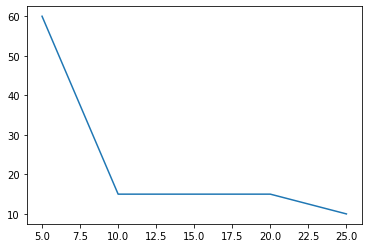

In [75]:
plt.plot(list(min_timeouts.keys()), list(min_timeouts.values()))

In [76]:
min_timeouts

{25: 10, 20: 15, 15: 15, 10: 15, 5: 60, 7: None}